c:\Users\debas\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 16s 122ms/step - loss: 0.4035 - val_loss: 0.3636
Epoch 2/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0406 - val_loss: 0.1338
Epoch 3/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0129 - val_loss: 0.0640
Epoch 4/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0069 - val_loss: 0.0267
Epoch 5/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0038 - val_loss: 0.0193
Epoch 6/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0022 - val_loss: 0.0084
Epoch 7/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0016 - val_loss: 0.0077
Epoch 8/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0013 - val_loss: 0.0059
Epoch 9/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0012 - val_loss: 0.0066
Epoch 10/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0011 - val_loss: 0.0064
Epoch 11/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0011 - val_loss: 0.0065
Epoch 12/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 96ms/step


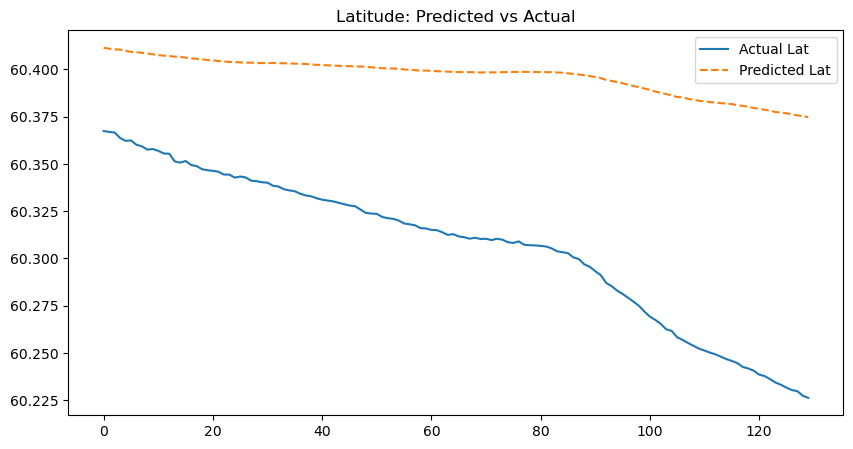

In [11]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import joblib

# Load dataset
df = pd.read_csv(r"C:\Users\debas\AIRTRAJ\dataset-research\validated_data\Oslo8.csv")

# Use only these 4 features (both input & output)
features = ['lat', 'lon', 'alt', 'time']
data = df[features]

# Scale features
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)

# Save the scaler
joblib.dump(scaler, "coord_scaler.pkl")

# Function to create sequences
def create_sequences(data, seq_length=10):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])  # Next timestep's coordinates
    return np.array(X), np.array(y)

SEQ_LENGTH = 10
X, y = create_sequences(data_scaled, SEQ_LENGTH)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Build model
model = Sequential([
    LSTM(64, input_shape=(SEQ_LENGTH, len(features)), activation='tanh'),
    Dense(4)  # 4 outputs: lat, lon, alt, time
])

model.compile(optimizer='adam', loss='mse')

# Train
history = model.fit(X_train, y_train, epochs=30, batch_size=32, validation_split=0.1)

# Save model
model.save("coord_predictor.h5")

# Predict and inverse scale
y_pred_scaled = model.predict(X_test)
y_pred = scaler.inverse_transform(y_pred_scaled)
y_true = scaler.inverse_transform(y_test)

# Plot predicted vs actual for latitude
plt.figure(figsize=(10, 5))
plt.plot(y_true[:, 0], label='Actual Lat')
plt.plot(y_pred[:, 0], label='Predicted Lat', linestyle='--')
plt.title("Latitude: Predicted vs Actual")
plt.legend()
plt.show()


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
import joblib
from mpl_toolkits.mplot3d import Axes3D
from tensorflow.keras.models import load_model

model = load_model("coord_predictor.h5", compile=False)
scaler = joblib.load("coord_scaler.pkl")

# Load your data again
df = pd.read_csv(r"C:\Users\debas\AIRTRAJ\dataset-research\validated_data\Oslo8.csv")
features = ['lat', 'lon', 'alt', 'time']
data = df[features]
data_scaled = scaler.transform(data)

# Recreate sequences
SEQ_LENGTH = 10
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

X, y = create_sequences(data_scaled, SEQ_LENGTH)

# Predict
y_pred_scaled = model.predict(X)
y_pred = scaler.inverse_transform(y_pred_scaled)
y_true = scaler.inverse_transform(y)

# Split coordinates for plotting
true_lat, true_lon, true_alt, true_time = y_true.T
pred_lat, pred_lon, pred_alt, pred_time = y_pred.T

# -------------------------------
# 📍 3D PLOT of LAT, LON, ALT
# -------------------------------
fig = plt.figure(figsize=(14, 6))

# 3D plot
ax = fig.add_subplot(121, projection='3d')
ax.plot(true_lat, true_lon, true_alt, label='Actual', alpha=0.7)
ax.plot(pred_lat, pred_lon, pred_alt, label='Predicted', linestyle='--', alpha=0.7)

ax.set_xlabel('Latitude')
ax.set_ylabel('Longitude')
ax.set_zlabel('Altitude')
ax.set_title('3D Trajectory: Actual vs Predicted')
ax.legend()

# -------------------------------
# 📍 Time Comparison
# -------------------------------
ax2 = fig.add_subplot(122)
ax2.plot(true_time, label='Actual Time', alpha=0.7)
ax2.plot(pred_time, label='Predicted Time', linestyle='--', alpha=0.7)
ax2.set_title('Time Prediction')
ax2.set_xlabel('Sequence Step')
ax2.set_ylabel('Time')
ax2.legend()

plt.tight_layout()
plt.show()


ValueError: Could not deserialize 'keras.metrics.mse' because it is not a KerasSaveable subclass

In [ ]:
from tensorflow.keras.models import load_model

model = load_model("coord_predictor.h5", compile=False)


In [ ]:
model.compile(optimizer='adam', loss='mse')


In [ ]:
model.save("coord_predictor.h5")
